In [10]:
import pandas as pd
from src.transform import Transform

# Load your data
df = data= Transform.Transform().livestock
df = df[df['Commodity_Description'] == 'Animal Numbers, Cattle']
df = Transform().transform_commodity_by_export(data=df)


ModuleNotFoundError: No module named 'src'

In [ ]:
import matplotlib.pyplot as plt
from prophet import Prophet

# Rename columns to fit Prophet's requirements
df.rename(columns={'Calendar_Year': 'ds', 'Value': 'y'}, inplace=True)
# Ensure the date column is parsed as yearly data
df['ds'] = pd.to_datetime(df['ds'], format='%Y')

# Initialize and fit the Prophet model
model = Prophet()
model.fit(df)

# Create a DataFrame for future dates (including historical dates)
future = model.make_future_dataframe(periods=0, freq='Y')

# Make predictions
forecast = model.predict(future)

# Extract the trend component
trend = forecast[['ds', 'trend']]

# Calculate residuals
df['trend'] = trend['trend']
df['residual'] = df['y'] - df['trend']

In [ ]:
df.head(10)

Step 2: Identify Trends
To identify periods of increasing or decreasing trends, you can calculate the first derivative of the trend component. This will give you the rate of change, which you can use to identify periods of increase or decrease.

In [ ]:
# Calculate the first derivative of the trend
trend['trend_diff'] = trend['trend'].diff()

# Identify periods of increase or decrease
trend['trend_direction'] = trend['trend_diff'].apply(lambda x: 'Increase' if x > 0 else 'Decrease' if x < 0 else 'No Change')

# Identify consecutive periods of increase or decrease
trend_periods = trend.groupby((trend['trend_direction'] != trend['trend_direction'].shift()).cumsum()).agg({
    'ds': ['first', 'last'],
    'trend_direction': 'first'
}).reset_index(drop=True)

# Rename columns
trend_periods.columns = ['Start', 'End', 'Direction']

Step 3: Identify Consistency and Volatility
To identify periods of consistency and volatility, calculate the rolling standard deviation of the residuals.

In [ ]:
# Calculate rolling standard deviation of residuals
df['rolling_std'] = df['residual'].rolling(window=12).std()  # 12-month rolling window

# Define thresholds for high and low volatility
high_volatility_threshold = df['rolling_std'].quantile(0.75)  # 75th percentile
low_volatility_threshold = df['rolling_std'].quantile(0.25)   # 25th percentile

# Identify periods of high and low volatility
df['volatility'] = df['rolling_std'].apply(lambda x: 'High' if x > high_volatility_threshold else 'Low' if x < low_volatility_threshold else 'Medium')

# Identify consecutive periods of high or low volatility
volatility_periods = df.groupby((df['volatility'] != df['volatility'].shift()).cumsum()).agg({
    'ds': ['first', 'last'],
    'volatility': 'first'
}).reset_index(drop=True)

# Rename columns
volatility_periods.columns = ['Start', 'End', 'Volatility']

Combine Results
Combine the results of trends and volatility analysis to get a comprehensive view of the time points when these events occur.

In [ ]:
# Combine trend and volatility periods
analysis_results = pd.concat([trend_periods, volatility_periods], axis=0).sort_values(by='Start')

# Print results
print(analysis_results)


Explanation
Trend Analysis: The trend component is analyzed to identify periods of increasing or decreasing trends.
Volatility Analysis: The rolling standard deviation of the residuals is calculated to identify periods of high and low volatility.
Combine Results: The results from both analyses are combined and sorted by the start date to give a comprehensive view of when trends, consistency, and volatility occur.
This approach allows you to pinpoint specific time points (years) when certain patterns or behaviors are present in your time series data.

Full Code

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import transform

# Load your data
df = data=transform.Transform().livestock
df = df[df['Commodity_Description'] == 'Animal Numbers, Cattle']
df = transform.Transform().transform_commodity_by_export(data=df)


# Rename columns to fit Prophet's requirements
df.rename(columns={'Calendar_Year': 'ds', 'Value': 'y'}, inplace=True)
# Ensure the date column is parsed as yearly data
df['ds'] = pd.to_datetime(df['ds'], format='%Y')

# Initialize and fit the Prophet model
model = Prophet()
model.fit(df)

# Create a DataFrame for future dates (including historical dates)
future = model.make_future_dataframe(periods=0, freq='Y')

# Make predictions
forecast = model.predict(future)

# Extract the trend component
trend = forecast[['ds', 'trend']]

# Ensure proper alignment
df = df.merge(trend, on='ds', how='left')

# Calculate residuals
df['residual'] = df['y'] - df['trend']

# Rename columns
trend_periods.columns = ['Start', 'End', 'Direction']

# Calculate rolling standard deviation of residuals to assess volatility
df['rolling_std'] = df['residual'].rolling(window=3, min_periods=1).std()  # 3-year rolling window with minimum periods

# Define thresholds for high and low volatility
high_volatility_threshold = df['rolling_std'].quantile(0.75)  # 75th percentile
low_volatility_threshold = df['rolling_std'].quantile(0.25)   # 25th percentile

# Identify periods of high and low volatility
df['volatility'] = df['rolling_std'].apply(lambda x: 'High' if x > high_volatility_threshold else 'Low' if x < low_volatility_threshold else 'Medium')

# Identify consecutive periods of high or low volatility
volatility_periods = df.groupby((df['volatility'] != df['volatility'].shift()).cumsum()).agg({
    'ds': ['first', 'last'],
    'volatility': 'first'
}).reset_index(drop=True)

# Rename columns
volatility_periods.columns = ['Start', 'End', 'Volatility']

# Combine trend and volatility periods
analysis_results = pd.concat([trend_periods, volatility_periods], axis=0).sort_values(by='Start')

# Print results
print(analysis_results)


12:32:47 - cmdstanpy - INFO - Chain [1] start processing
12:32:47 - cmdstanpy - INFO - Chain [1] done processing


        Start        End  Direction Volatility
0  1960-01-01 1960-01-01  No Change        NaN
0  1960-01-01 1962-01-01        NaN     Medium
1  1961-01-01 2022-01-01   Increase        NaN
1  1963-01-01 1965-01-01        NaN        Low
2  1966-01-01 1966-01-01        NaN     Medium
3  1967-01-01 1967-01-01        NaN        Low
4  1968-01-01 1970-01-01        NaN     Medium
5  1971-01-01 1973-01-01        NaN        Low
6  1974-01-01 1976-01-01        NaN     Medium
7  1977-01-01 1979-01-01        NaN        Low
8  1980-01-01 1981-01-01        NaN     Medium
9  1982-01-01 1983-01-01        NaN        Low
10 1984-01-01 1984-01-01        NaN     Medium
11 1985-01-01 1985-01-01        NaN        Low
12 1986-01-01 1991-01-01        NaN     Medium
13 1992-01-01 1992-01-01        NaN        Low
14 1993-01-01 1994-01-01        NaN       High
15 1995-01-01 1998-01-01        NaN     Medium
16 1999-01-01 1999-01-01        NaN       High
17 2000-01-01 2000-01-01        NaN        Low
18 2001-01-01

/opt/miniconda3/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


This visualization will highlight periods of different volatility levels on your time series plot, making it easier to identify and interpret these periods in the context of your data.

By analyzing these results and visualizations, you can gain insights into the behavior of your time series data, identify key periods of change, and understand the underlying patterns and factors driving these changes.

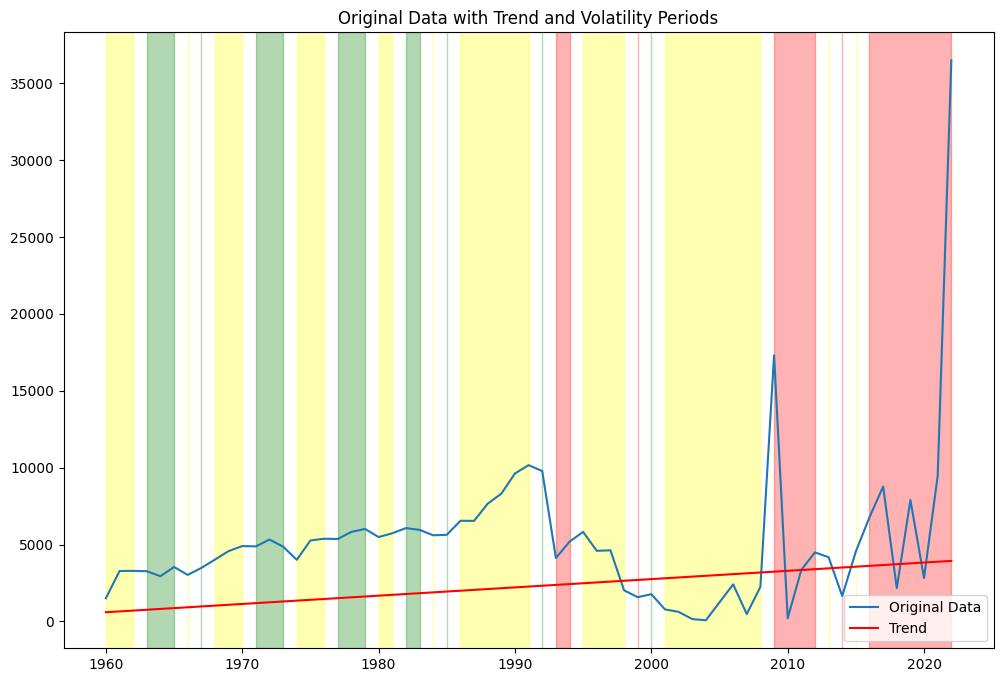

In [10]:
import matplotlib.pyplot as plt

# Plot original data with trend and volatility periods
plt.figure(figsize=(12, 8))
plt.plot(df['ds'], df['y'], label='Original Data')
plt.plot(df['ds'], df['trend'], label='Trend', color='red')

# Highlight periods of high, medium, and low volatility
for _, row in volatility_periods.iterrows():
    plt.axvspan(row['Start'], row['End'], color='yellow' if row['Volatility'] == 'Medium' else 'red' if row['Volatility'] == 'High' else 'green', alpha=0.3)

plt.legend()
plt.title('Original Data with Trend and Volatility Periods')
plt.show()